## Import libs

In [1]:
from math import sqrt, isnan
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from util import metrics
from util.load_data import load_data
from util.evaluation import compute_tradeoff

from zhang.models import UnfairLogisticRegression

## Preliminaries

In [2]:
batch_size = 64
epochs = 50
lr = 0.001
opt = Adam(learning_rate=lr)

In [3]:
header = "model_name", "clas_acc", "dp", "deqodds", "deqopp", "trade_dp", "trade_deqodds", "trade_deqopp", "TN_a0", "FP_a0", "FN_a0", "TP_a0", "TN_a1", "FP_a1", "FN_a1", "TP_a1"
results = []

test_loop = 5

## Load data

In [4]:
x_train, y_train, a_train = load_data('adult', 'train')
raw_data = (x_train, y_train, a_train)

In [5]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]
zdim = 8

In [6]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data

<BatchDataset shapes: ((64, 113), (64, 1), (64, 1)), types: (tf.float64, tf.float64, tf.float64)>

In [7]:
x_valid, y_valid, a_valid = load_data('adult', 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [8]:
x_test, y_test, a_test = load_data('adult', 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Train loop

In [9]:
def train(model, X, Y, A, optimizer):
    clas_vars = [model.clas.W, model.b]
    
    with tf.GradientTape() as clas_tape:
        
        model(X, Y, A)        
        clas_loss = model.clas_loss

    dWLp = clas_tape.gradient(clas_loss, clas_vars)
    optimizer.apply_gradients(zip(dWLp, clas_vars))

In [10]:
def train_loop(model, train_dataset, epochs, opt=None):
    
    print("> Epoch | Class Loss | Class Acc")

    if opt is not None:
        optimizer = opt
        decay4epoch = False
    else:
        decay4epoch = True
    
    for epoch in range(epochs):
        Y_hat = None
        batch_count = 1

        if decay4epoch:
            lr = 0.001/(epoch+1)
            optimizer = Adam(learning_rate=lr)
        
        for X, Y, A in train_dataset:
            
            r = train(model, X, Y, A, optimizer)
            if r:
                print('parou')
                print(model.clas_loss)
                break

            if batch_count == 1:
                Y_hat = model.Y_hat
                batch_count += 1
            else:
                Y_hat = tf.concat([Y_hat, model.Y_hat], 0)

        clas_loss = model.clas_loss
        clas_acc = metrics.accuracy(raw_data[1], tf.math.round(Y_hat))

        
    
        print("> {} | {} | {}".format(
            epoch+1, 
            clas_loss, 
            clas_acc))

## Evaluation

In [11]:

def evaluation(model, valid_data):
    Y_hat = None
    batch_count = 1
    
    for X, Y, A in valid_data:
        
        model(X, Y, A)
        
        if batch_count == 1:
            Y_hat = model.Y_hat
            batch_count += 1
        else:
            Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
    
    return Y_hat

In [12]:
def compute_metrics(Y, Y_hat, A):
    Y_hat = tf.math.round(Y_hat)
    
    clas_acc = metrics.accuracy(Y, Y_hat)

    print("> Class Acc")
    print("> {}".format(clas_acc))

    dp = metrics.DP(Y_hat.numpy(), A)
    deqodds = metrics.DEqOdds(Y, Y_hat.numpy(), A)
    deqopp = metrics.DEqOpp(Y, Y_hat.numpy(), A)

    print("> DP | DI | DEOPP")
    print("> {} | {} | {}".format(dp, deqodds, deqopp))

    tp = metrics.TP(Y, Y_hat.numpy())
    tn = metrics.TN(Y, Y_hat.numpy())
    fp = metrics.FP(Y, Y_hat.numpy())
    fn = metrics.FN(Y, Y_hat.numpy())

    print('> Confusion Matrix \n' +
                'TN: {} | FP: {} \n'.format(tn, fp) +
                'FN: {} | TP: {}'.format(fn, tp))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    m = [metrics.TN, metrics.FP, metrics.FN, metrics.TP]
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    for i in range(len(m)):
        metrics_a0[i] = metrics.subgroup(m[i], A, Y, Y_hat.numpy())
        metrics_a1[i] = metrics.subgroup(m[i], 1 - A, Y, Y_hat.numpy())

    print('> Confusion Matrix for A = 0 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a0[0], metrics_a0[1]) +
            'FN: {} | TP: {}'.format(metrics_a0[2], metrics_a0[3]))

    print('> Confusion Matrix for A = 1 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a1[0], metrics_a1[1]) +
            'FN: {} | TP: {}'.format(metrics_a1[2], metrics_a1[3]))

    confusion_matrix = np.array([[tn, fp],
                                [fn, tp]])

    return clas_acc, confusion_matrix, dp, deqodds, deqopp, metrics_a0, metrics_a1

## Testing

In [13]:
for i in range(test_loop):

    model = UnfairLogisticRegression(xdim, batch_size)
    ret = train_loop(model, train_data, epochs)
    Y_hat = evaluation(model, valid_data)
    
    clas_acc, confusion_matrix, dp, deqodds, deqopp, metrics_a0, metrics_a1  = compute_metrics(y_valid, Y_hat, a_valid)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR-decay', clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

> Epoch | Class Loss | Class Acc
> 1 | 0.5004817843437195 | 0.7487566312997347
> 2 | 0.4250468909740448 | 0.7940981432360743
> 3 | 0.38422220945358276 | 0.8143236074270557
> 4 | 0.36236947774887085 | 0.8235245358090186
> 5 | 0.35435330867767334 | 0.8309433023872679
> 6 | 0.3480228781700134 | 0.8362068965517242
> 7 | 0.3438219428062439 | 0.8391495358090186
> 8 | 0.34053272008895874 | 0.8399370026525199
> 9 | 0.33758699893951416 | 0.8413461538461539
> 10 | 0.3348346948623657 | 0.8418849469496021
> 11 | 0.33249279856681824 | 0.8425895225464191
> 12 | 0.3304925858974457 | 0.8430039787798409
> 13 | 0.3288639783859253 | 0.8434184350132626
> 14 | 0.3274797797203064 | 0.8440401193633953
> 15 | 0.32632455229759216 | 0.8445789124668435
> 16 | 0.3253505527973175 | 0.8450348143236074
> 17 | 0.32451677322387695 | 0.8451591511936339
> 18 | 0.3237929940223694 | 0.8454078249336869
> 19 | 0.323161780834198 | 0.8455736074270557
> 20 | 0.32261425256729126 | 0.8460709549071618
> 21 | 0.3222368061542511 | 

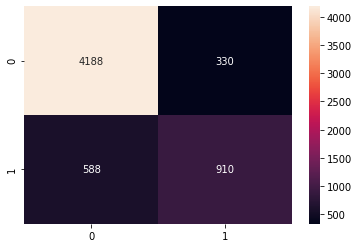

In [14]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

In [15]:
for i in range(test_loop):
    opt = Adam(learning_rate=lr)

    model = UnfairLogisticRegression(xdim, batch_size)
    ret = train_loop(model, train_data, epochs, opt)
    Y_hat = evaluation(model, valid_data)
    
    clas_acc, confusion_matrix, dp, deqodds, deqopp, metrics_a0, metrics_a1  = compute_metrics(y_valid, Y_hat, a_valid)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR', clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

> Epoch | Class Loss | Class Acc
> 1 | 0.5004817843437195 | 0.7487566312997347
> 2 | 0.43046826124191284 | 0.7967092175066313
> 3 | 0.4265057444572449 | 0.8164787798408488
> 4 | 0.3977872431278229 | 0.828125
> 5 | 0.3788052797317505 | 0.8338030503978779
> 6 | 0.3722444176673889 | 0.8389837533156499
> 7 | 0.35932254791259766 | 0.8396468832891246
> 8 | 0.365489661693573 | 0.8395639920424403
> 9 | 0.35043689608573914 | 0.841387599469496
> 10 | 0.35543712973594666 | 0.8425480769230769
> 11 | 0.34435534477233887 | 0.8445374668435013
> 12 | 0.9974395036697388 | 0.8433355437665783
> 13 | 0.33965668082237244 | 0.839729774535809
> 14 | 0.531301736831665 | 0.8430868700265252
> 15 | 0.3296221196651459 | 0.8480603448275862
> 16 | 0.9852874875068665 | 0.8441644562334217
> 17 | 0.9825006127357483 | 0.8331399204244032
> 18 | 0.33471840620040894 | 0.8358338859416445
> 19 | 0.32079070806503296 | 0.8455321618037135
> 20 | 0.31524109840393066 | 0.8468998673740054
> 21 | 0.3298489451408386 | 0.84677553050

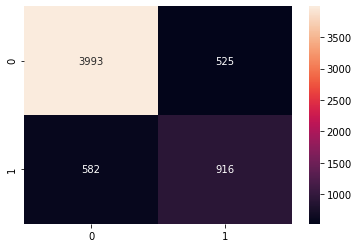

In [16]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

## Saving into DF then CSV

In [17]:
result_df = pd.DataFrame(results, columns=header)
result_df

,model_name,clas_acc,dp,deqodds,deqopp,trade_dp,trade_deqodds,trade_deqopp,TN_a0,FP_a0,FN_a0,TP_a0,TN_a1,FP_a1,FN_a1,TP_a1
0,UnfairLR-decay,0.847407,0.800875,0.877304,0.841838,0.823484,0.862096,0.844613,1637.0,30.0,112.0,100.0,2551.0,300.0,476.0,810.0
1,UnfairLR-decay,0.847407,0.800875,0.877304,0.841838,0.823484,0.862096,0.844613,1637.0,30.0,112.0,100.0,2551.0,300.0,476.0,810.0
2,UnfairLR-decay,0.847407,0.800875,0.877304,0.841838,0.823484,0.862096,0.844613,1637.0,30.0,112.0,100.0,2551.0,300.0,476.0,810.0
3,UnfairLR-decay,0.847407,0.800875,0.877304,0.841838,0.823484,0.862096,0.844613,1637.0,30.0,112.0,100.0,2551.0,300.0,476.0,810.0
4,UnfairLR-decay,0.847407,0.800875,0.877304,0.841838,0.823484,0.862096,0.844613,1637.0,30.0,112.0,100.0,2551.0,300.0,476.0,810.0
5,UnfairLR,0.815991,0.825812,0.940455,0.969043,0.820872,0.873813,0.885955,1566.0,101.0,88.0,124.0,2427.0,424.0,494.0,792.0
6,UnfairLR,0.815991,0.825812,0.940455,0.969043,0.820872,0.873813,0.885955,1566.0,101.0,88.0,124.0,2427.0,424.0,494.0,792.0
7,UnfairLR,0.815991,0.825812,0.940455,0.969043,0.820872,0.873813,0.885955,1566.0,101.0,88.0,124.0,2427.0,424.0,494.0,792.0
8,UnfairLR,0.815991,0.825812,0.940455,0.969043,0.820872,0.873813,0.885955,1566.0,101.0,88.0,124.0,2427.0,424.0,494.0,792.0
9,UnfairLR,0.815991,0.825812,0.940455,0.969043,0.820872,0.873813,0.885955,1566.0,101.0,88.0,124.0,2427.0,424.0,494.0,792.0


In [18]:
result_df.to_csv('results/validation_unfair_lr-50.csv')